# ADA project: Milestone 2
### Team: YiYiSoDa - Yinghui Jiang, Yichen Wang, Sophia Ly, David Chaves

In [1]:
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import tarfile
import re
import gzip
import spacy

data_folder = './data/MovieSummaries/'
corenlp_folder = './data/corenlp_plot_summaries/'

### Task 1: Explore the dataset

#### 1.1 Load the data

#### movie.metadata.tsv.gz


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


In [2]:
moives = data_folder + 'movie.metadata.tsv'
moives_cols = ['wiki_movie_id', 'freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'languages', 'countries','genres']

movies = pd.read_csv(moives, sep='\t', names=moives_cols, parse_dates=["release_date"], date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
movies.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,movie_runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


All movies in the dataset contains information about languages, countries and genres. These three columns can contain multiple info. 

In [3]:
# relational table between movies with lauguages, countries and genres.
# keep wiki_movie_id, lauguages, countries, genres

movie_languages = movies.copy()
movie_languages['languages'] = movie_languages['languages'].apply(lambda x: list(eval(x).values()))
movie_languages = movie_languages.explode('languages', ignore_index = True)
movie_languages = movie_languages.drop(columns=['freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'countries','genres'])
movie_languages.languages.value_counts()

English Language                        40891
Hindi Language                           3744
Spanish Language                         3673
French Language                          3422
Silent film                              3183
                                        ...  
Southwestern Mandarin                       1
Australian Aboriginal Pidgin English        1
Tok Pisin Language                          1
Pawnee Language                             1
Kuna language                               1
Name: languages, Length: 207, dtype: int64

In [4]:
movie_countries = movies.copy()
movie_countries['countries'] = movie_countries['countries'].apply(lambda x: list(eval(x).values()))
movie_countries = movie_countries.explode('countries', ignore_index = True)
movie_countries = movie_countries.drop(columns=['freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'languages','genres'])
movie_countries.countries.value_counts()

United States of America    34408
India                        8411
United Kingdom               7868
France                       4395
Italy                        3163
                            ...  
Republic of China               1
Macau                           1
Palestinian Territories         1
German Language                 1
Ukranian SSR                    1
Name: countries, Length: 147, dtype: int64

In [55]:
movie_genres = movies.copy()
movie_genres['genres'] = movie_genres['genres'].apply(lambda x: list(eval(x).values()))
movie_genres = movie_genres.explode('genres', ignore_index = True)
movie_genres = movie_genres.drop(columns=['freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'languages','countries'])
top30_genres = movie_genres['genres'].value_counts()[:30].index.tolist()
movie_genres['genres'].value_counts()

Drama                   34007
Comedy                  16349
Romance Film            10234
Black-and-white          9094
Action                   8798
                        ...  
Romantic thriller           1
Comdedy                     1
C-Movie                     1
Silhouette animation        1
Homoeroticism               1
Name: genres, Length: 363, dtype: int64

#### character.metadata.tsv.gz

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


In [6]:
characters = data_folder + 'character.metadata.tsv'
char_cols = ['wiki_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 'actor_date_of_birth', 
             'actor_gender', 'height', 'actor_ethnicity', 'actor_name', 'actor_age_at_release', 'freebase_map_id', 'freebase_character_id', 'freebase_actor_id']
characters = pd.read_csv(characters, sep='\t', names=char_cols, parse_dates=["release_date"], date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
characters.head()

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_date_of_birth,actor_gender,height,actor_ethnicity,actor_name,actor_age_at_release,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [7]:
print('number of movies:\t{}\nnumber of characters:\t{}\nwith gender info:\t{}\nnegative age:\t\t{}'.format(characters.wiki_movie_id.unique().size, len(characters),characters.actor_gender.notnull().sum(), len(characters.query('actor_age_at_release <= 0'))))
characters.actor_gender.value_counts()

number of movies:	64330
number of characters:	450669
with gender info:	405060
negative age:		433


M    270257
F    134803
Name: actor_gender, dtype: int64

In [8]:
# drop characters has no gender info
characters = characters.loc[characters.actor_gender.notnull()]

 ********* how to deal with age? 
 For age distribution, check on actor age, contains nan and negative values

In [9]:
characters.query('actor_age_at_release <= 0')[['wiki_movie_id', 'actor_name', 'release_date', 'actor_date_of_birth','actor_age_at_release']]

,wiki_movie_id,actor_name,release_date,actor_date_of_birth,actor_age_at_release
2286,2553539,Tom Wilson,1918-04-14,1931-03-25,-12.0
3892,5917218,Kim Smith,1965-01-01,1983-03-03,-18.0
6666,73930,Jason London,1924-01-01,1972-11-07,-48.0
7188,21242801,Eduardo Noriega,1955-08-07,1973-08-01,-17.0
10491,44749,Joe Brown,1929-01-01,1941-05-13,-12.0
...,...,...,...,...,...
446570,3642891,J.J. McColl,1999-10-03,2936-12-24,-937.0
446581,25868401,Sandrine Bonnaire,1955-01-01,1967-05-31,-12.0
446583,8595532,Kevin O'Shea,1944-02-23,1947-05-28,-3.0
446816,1276915,Tony Martin,1941-06-20,1957-04-19,-15.0


In [10]:
characters[characters['actor_age_at_release'].isna()][['wiki_movie_id', 'actor_name', 'release_date', 'actor_date_of_birth','actor_age_at_release']]

,wiki_movie_id,actor_name,release_date,actor_date_of_birth,actor_age_at_release
7,975900,Richard Cetrone,2001-08-24,NaN,NaN
9,975900,Duane Davis,2001-08-24,NaN,NaN
10,975900,Lobo Sebastian,2001-08-24,NaN,NaN
13,975900,Rick Edelstein,2001-08-24,NaN,NaN
17,3196793,Allen Cutler,2000-02-16,NaN,NaN
...,...,...,...,...,...
450648,12476867,Wendy Anderson,2002-01-01,NaN,NaN
450656,913762,Steve Areno,1992-05-21,NaN,NaN
450659,913762,Violet Bronte,1992-05-21,NaN,NaN
450663,913762,Hal Cleaveland,1992-05-21,NaN,NaN


In [51]:
def get_female_ratio(s):
    female_count = 0
    for i in range(len(s)):
        if s[i] == 'F':
            female_count = female_count+1
    return round(female_count/len(s), 4)

character_genres = pd.merge(left = characters, right = movie_genres, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')
female_genres = character_genres[['actor_gender', 'genres']].groupby('genres').agg('sum')
female_genres['female_ratio'] = female_genres['actor_gender'].apply(lambda x: get_female_ratio(x))
female_genres = female_genres.drop(columns=['actor_gender'])
female_genres = female_genres.sort_values(by='female_ratio', ascending=False).iloc[:30]

[Text(0.5, 1.0, 'Top 30 Female Genres')]

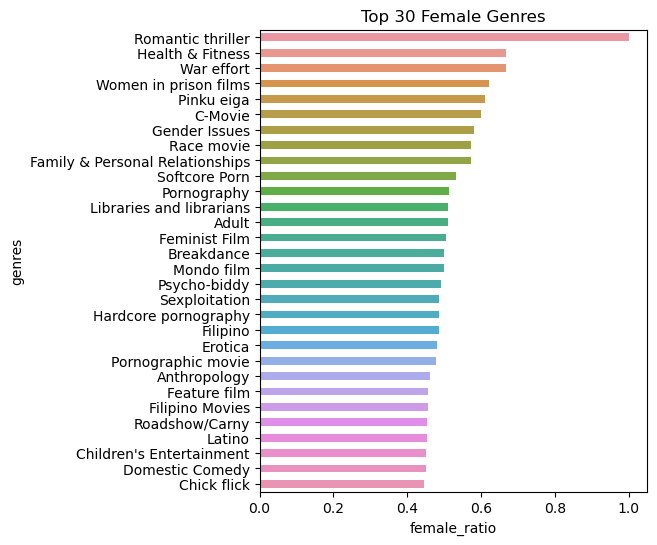

In [52]:
female_genres['genres'] = female_genres.index
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=female_genres, x="female_ratio", y="genres",  width=0.5).set(title='Top 30 Female Genres')

In [53]:
genre_gender = character_genres[character_genres.genres.isin(top30_genres)][['actor_gender', 'genres']].groupby('genres').agg('sum')
genre_gender['female_ratio'] = genre_gender['actor_gender'].apply(lambda x: get_female_ratio(x))
genre_gender = genre_gender.drop(columns=['actor_gender'])
genre_gender = genre_gender.sort_values(by='female_ratio', ascending=False)

[Text(0.5, 1.0, 'Female cast ratio in top 30 genres')]

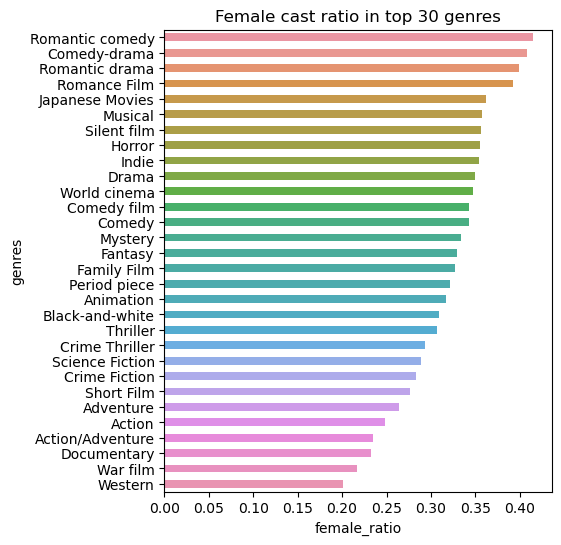

In [54]:
genre_gender['genres'] = genre_gender.index
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=genre_gender, x="female_ratio", y="genres",  width=0.5).set(title='Female cast ratio in top 30 genres')

#### plot_summaries.txt

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [5]:
plots =  pd.read_csv(data_folder + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_movie_id','plot'))
plots.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [89]:
movies_with_plots = pd.merge(left = movies, right = plots, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')
print('number of movies:\t{}\nnumber of plots:\t{}\ncombined info:\t\t{}'.format(characters.wiki_movie_id.unique().size, len(plots), len(movies_with_plots)))
movies_with_plots.head(3)

number of movies:	64330
number of plots:	42303
combined info:		42204


,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,movie_runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


#### tvtropes.clusters.txt

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

In [6]:
tvtropes = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep = '\t', header=None, names=('char_type', 'details'))

# split the details to seprate columns
details = tvtropes['details'].str.slice(start=1, stop=-1).str.split('", "|": "', expand=True)

tvtropes['char_name'] = details[1]
tvtropes['movie_name'] = details[3]
tvtropes['freebase_map_id'] = details[5]
tvtropes['actor_name'] = details[7].str.replace('"' ,'',regex=True)
tvtropes.drop(columns=['details'], inplace = True)
tvtropes.head()

,char_type,char_name,movie_name,freebase_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


#### title.crew.tsv.gz

Contains the director and writer information for all the titles in IMDb.

1. tconst (string) - alphanumeric unique identifier of the title
2. Directors (array of nconsts) - director(s) of the given title
3. Writers (array of nconsts) – writer(s) of the given title

In [7]:
crew = pd.read_csv('data/title.crew.tsv.gz', compression='gzip', sep='\t', na_values="\\N")
crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


To link the titles of the movies and the writers/directors we need two additional dataset:
1. title.akas.tsv.gz, that contains titles and tconst
2. data/name.basics.tsv.gz, that contains writers/directors id and their ids


In [8]:
titles = pd.read_csv('data/title.akas.tsv.gz', compression='gzip', sep='\t', na_values="\\N", usecols=['titleId', 'title'], low_memory=True)
titles = titles.rename(columns={'titleId' : 'tconst'})
titles.head()

,tconst,title
0,tt0000001,Карменсіта
1,tt0000001,Carmencita
2,tt0000001,Carmencita - spanyol tánc
3,tt0000001,Καρμενσίτα
4,tt0000001,Карменсита


In [9]:
## Inner join titles and metadata to only keep the movies that are in the original set
titles = pd.merge(titles, movies.rename(columns={'movie_name' : 'title'}).title, on='title', how='inner')
titles.head()

,tconst,title
0,tt0000001,Carmencita
1,tt0000001,Carmencita
2,tt0000001,Carmencita
3,tt0021748,Carmencita
4,tt0028162,Carmencita


In [10]:
## Inner join crew and titles on tconst to have the title name with the directors and writers
crew = pd.merge(crew, titles, on='tconst', how='inner')
crew.drop('tconst', axis=1, inplace=True) ## Drop useless column "tconst"
crew = crew.drop_duplicates() ## Drop duplicates i.e. titles that have multiple "tconst" values
del titles ## Free memory
crew.head()

,directors,writers,title
0,nm0005690,NaN,Carmencita
3,nm0721526,NaN,Pauvre Pierrot
5,nm0721526,NaN,Un bon bock
7,nm0005690,NaN,Blacksmith Scene
10,nm0005690,NaN,Chinese Opium Den


In [11]:
# Create two data frame for directors and writers, and drop the row without directors and writers.
directors = crew[['directors', 'title']].dropna()
writers = crew[['title', 'writers']].dropna()

In [12]:
# Directors and writers are list, so we transform them into rows
directors['directors'] = directors['directors'].str.split(pat=',')
writers['writers'] = writers['writers'].str.split(pat=',')
directors = directors.explode('directors')
writers = writers.explode('writers')

In [13]:
names = pd.read_csv('data/name.basics.tsv.gz', compression='gzip', sep='\t', na_values="\\N", usecols=['nconst', 'primaryName'], low_memory=True)
names.head()

,nconst,primaryName
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman


In [14]:
directors = pd.merge(directors, names.rename(columns={'nconst' : 'directors'})[['directors', 'primaryName']],
                     on='directors', how='inner')
directors.drop('directors', axis=1, inplace=True)
directors.rename(columns={'primaryName' : 'director_name'}, inplace=True)
directors = directors.drop_duplicates()
directors.head()

,title,director_name
0,Carmencita,William K.L. Dickson
1,Blacksmith Scene,William K.L. Dickson
2,Chinese Opium Den,William K.L. Dickson
3,Corbett and Courtney Before the Kinetograph,William K.L. Dickson
4,Fred Ott's Sneeze,William K.L. Dickson


In [15]:
writers = pd.merge(writers, names.rename(columns={'nconst' : 'writers'})[['writers', 'primaryName']],
                   on='writers', how='inner')
writers.drop('writers', axis=1, inplace=True)
writers.rename(columns={'primaryName' : 'writer_name'}, inplace=True)
writers = writers.drop_duplicates()
del names ## Free memory
writers.head()

,title,writer_name
0,Miss Jerry,Alexander Black
1,Awakening of Rip,Washington Irving
2,Rip Van Winkle,Washington Irving
6,Have You Got Any Castles?,Washington Irving
7,The Adventures of Ichabod and Mr. Toad,Washington Irving


### Clean the dataframe

#### corenlp_plot_summaries.tar.gz

The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

In [16]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities") # Merge entities like ['David' 'Bowie'] to ['David Bowie']

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [17]:
def tag_adj(text):
    """
    Find all noon/adjective pair in the given text
    :param text: Text composed of one or multiple sentences
    :return: list of noon/adjective pair
    """
    doc = nlp(text)
    noun_adj_pairs = []
    for token in doc:
        ## Is the word a proper noun / noun / pronoun
        if token.pos_ in ('PROPN', 'NOUN', 'PRON'):
            for child in token.children:
                ## Is the child an adjectival modifier
                if child.dep_ == 'amod':
                    noun_adj_pairs.append((token.lemma_, child.lemma_))
    return noun_adj_pairs

In [18]:
## Example
print(tag_adj("There is a red card in the blue envelope and a beautiful girl."))
print(tag_adj("She is beautiful."))

[('card', 'red'), ('envelope', 'blue'), ('girl', 'beautiful')]
[]


In [19]:
def tag_verb(text):
    """
    Find all noon/verb pair in the given text
    :param text: Text composed of one or multiple sentences
    :return: list of noon/verb pair
    """
    doc = nlp(text)
    verbs = []
    for possible_verb in doc:
        if possible_verb.pos_ == 'VERB':
            for possible_subject in possible_verb.children:
                if possible_subject.dep_ == 'nsubj':
                    verbs.append((possible_subject.lemma_, possible_verb.lemma_))
                    break
    return verbs

In [20]:
tag_verb(plots.loc[1]['plot'])

[('nation', 'consist'),
 ('district', 'provide'),
 ('tribute', 'fight'),
 ('who', 'give'),
 ('she', 'starve'),
 ('he', 'warn'),
 ('who', 'train'),
 ('Peeta', 'reveal'),
 ('sponsor', 'provide'),
 ('she', 'discover'),
 ('Peeta', 'mean'),
 ('he', 'say'),
 ('Games', 'begin'),
 ('Katniss', 'survive'),
 ('Peeta', 'form'),
 ('they', 'find'),
 ('rue', 'draw'),
 ('Katniss', 'drop'),
 ('rue', 'care'),
 ('she', 'recover'),
 ('alliance', 'gather'),
 ('Katniss', 'draw'),
 ('Cato', 'kill'),
 ('Katniss', 'run'),
 ('she', 'hear'),
 ('she', 'find'),
 ('Rue', 'trap'),
 ('Marvel', 'throw'),
 ('she', 'dodge'),
 ('it', 'stab'),
 ('Katniss', 'shoot'),
 ('she', 'comfort'),
 ('she', 'gather'),
 ('it', 'spark'),
 ('Games', 'turn'),
 ('change', 'avoid'),
 ('tribute', 'win'),
 ('she', 'portray'),
 ('announcer', 'proclaim'),
 ('thing', 'need'),
 ('Peeta', 'beg'),
 ('Katniss', 'promise'),
 ('he', 'fall'),
 ('she', 'head'),
 ('Clove', 'ambush'),
 ('Thresh', 'kill'),
 ('he', 'spare'),
 ('medicine', 'work'),
 ('Foxfa

In [21]:
tag_adj(plots.loc[1]['plot'])

[('Capitol', 'wealthy'),
 ('district', 'poor'),
 ('rebellion', 'past'),
 ('Hunger Games', 'annual'),
 ('survivor', 'sole'),
 ('reaping', 'first'),
 ('Everdeen', '12-year-old'),
 ('sister', 'old'),
 ('tribute', 'other'),
 ('mentor', 'drunk'),
 ('Haymitch Abernathy', 'past'),
 ('academy', 'special'),
 ('Games', 'televise'),
 ('supply', 'tempting'),
 ('alliance', 'uneasy'),
 ('tree', 'nearby'),
 ('nest', 'poisonous'),
 ('Rue', 'die'),
 ('lover', 'cross'),
 ('riot', 'further'),
 ('district', 'same'),
 ('wound', 'infected'),
 ('tribute', 'other'),
 ('mobile', 'peeta'),
 ('creature', 'like'),
 ('death', 'prolonged'),
 ('Games', '74th'),
 ('enemy', 'powerful')]

In [ ]:
plots['verb'] = plots['plot'].apply(tag_verb) # long computation

In [ ]:
plots['adj'] = plots['plot'].apply(tag_adj) # long computation

In [24]:
# Dict that match all characters to their gender
matcher = pd.Series(characters.actor_gender.values, index=characters.character_name).to_dict()
matcher.update({'he' : 'M', 'she' : 'F'})

In [25]:
#Test
v = pd.DataFrame(tag_verb(plots.loc[1]['plot']), columns=['name', 'verb'])
v['gender'] = v.name.apply(matcher.get)
v.dropna()

,name,verb,gender
4,she,starve,F
5,he,warn,M
9,she,discover,F
11,he,say,M
19,she,recover,F
22,Cato,kill,M
24,she,hear,F
25,she,find,F
26,Rue,trap,F
27,Marvel,throw,M
